In [109]:
from importlib import reload
from copy import deepcopy
import os
from utils.data import MyData
from utils import utils
from torch.utils.data import DataLoader
import torch
import torchvision
from torchvision.transforms import ToTensor, RandomCrop, Compose
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
if not os.path.isdir("./cache"): os.mkdir("cache")
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'device: {device}')
print("Preparing data...")
mData = MyData()
print("Data is ready")

device: cuda
Preparing data...
Data is ready


## Net 12

In [16]:
Net12 = nn.Sequential(
    # 3 X 12 X 12
    nn.Conv2d(3, 16, kernel_size = 3, stride = 1),
    # 16 X 10 X 10
    utils.nn_Unsqueeze(1),
    # 1 X  16 X 10 X 10
    nn.MaxPool3d(kernel_size = [16, 3, 3], stride = 2),
    # 1 X 4 X 4
    nn.Flatten(),
    nn.Linear(4 * 4, 2)
)

Net12.to(device)
# train

model_path = "./cache/models.12Net.best_model"
if os.path.isfile(model_path):
    best_model = torch.load(model_path)

else:
    opt = optim.Adam(Net12.parameters(), lr=  2e-4)
    loss_fn = nn.CrossEntropyLoss()
    E = 100
    l_loss, l_acc = {'train':[], 'test':[]}, {'train':[], 'test':[]}
    best_model, best_acc = None ,0
    for epoch in range(E):
        dl = mData.DataLoader(12, typ = 'train', batch_size = 256)
        dl_test = mData.DataLoader(12, typ = 'test', batch_size = 256)
        epoch_loss, epoch_acc = 0, 0
        # train epoch
        for x, y in dl:
            x, y = x.to(device), y.view(-1).type(torch.int64).to(device)
            y_pred = Net12(x)
            loss = loss_fn(y_pred, y)
            opt.zero_grad() ; loss.backward() ; opt.step()
            with torch.no_grad():
                epoch_acc += (y_pred.cpu().argmax(axis=1) == y.cpu()).type(torch.float32).mean()
            epoch_loss += loss 
        l_loss['train'].append(epoch_loss / len(dl))
        l_acc['train'].append(epoch_acc / len(dl))
        epoch_loss, epoch_acc = 0, 0
        # test
        for x,y in dl_test:
            x, y = x.to(device), y.view(-1).type(torch.int64).to(device)
            with torch.no_grad():
                y_pred = Net12(x)
                loss = loss_fn(y_pred, y)
                epoch_acc += (y_pred.cpu().argmax(axis=1) == y.cpu()).type(torch.float32).mean()
            epoch_loss += loss 
        # update best model
        l_loss['test'].append(epoch_loss / len(dl_test))
        l_acc['test'].append(epoch_acc / len(dl_test))
        if l_acc['test'][-1] > best_acc:
            best_acc = l_acc['test'][-1]
            best_model = deepcopy(Net12)
        if epoch % 100 == 0: 
            utils.print_during_train(epoch,l_loss, l_acc)
    torch.save(best_model.cpu(), model_path)

>>> Epoch 0, train: loss 0.7203 acc 0.3432, test: loss 0.7154 acc 0.3561, 


## Simple Detector

In [150]:
Net12 = torch.load("cache/models.12Net.best_model").to(device)
Net12_layers = list(Net12._modules.values())
conv_layer = nn.Conv2d(1, 2, kernel_size = 4, stride = 1)
conv_layer.weight.data = Net12_layers[-1].weight.data.view((2, 1, 4, 4)).detach().clone()
conv_layer.bias.data = Net12_layers[-1].bias.data.detach().clone()
Net12Detector_layers = [deepcopy(l) for l in Net12_layers[:-2]] + [utils.nn_Squeeze(1), conv_layer, nn.Softmax(dim = 1)]
Net12_FCN = nn.Sequential(*Net12Detector_layers)

In [183]:
Net12_FCN(x).shape

torch.Size([2, 2, 132, 132])

In [206]:
Net12_FCN(x).size()

torch.Size([2, 2, 132, 132])

In [240]:
reload(utils)
x = torch.rand((2, 3,273, 273))
out = Net12_FCN(x)

### FDDB

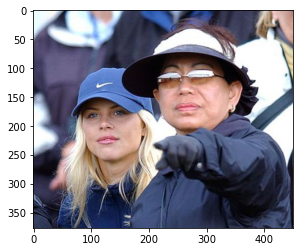

In [247]:
from PIL import Image
x = Image.open("./data/EX2_data/fddb/images/2002/07/19/big/img_488.jpg")
plt.imshow(x)